##*Do Pretrained Embeddings Give You The Extra Edge?*
By Nakshatra Singh

This notebook will show you if *Pretrained Word Embeddings* give you an edge while training models.

##Using Google GPU for Training

Google colab offers free GPUs and TPUs! Since we'll be training a large model it's best to take advantage of this (in this case we'll use GPU), otherwise training can take long time.

A GPU can be added by going to the menu and selecting:

`Edit -> Notebook Settings -> Hardware Accelerator -> (GPU)`

Then run the following cell to confirm that a GPU is detected.

In [1]:
import tensorflow as tf
# Get the device GPU name 
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
  print('Found GPU at : {}'.format(device_name)) 
else:
  raise SystemError('GPU not found!') 

Found GPU at : /device:GPU:0


###**1. Retrieve and Inspect Dataset** 

Let's download the dataset which is uploaded on my google drive. 

In [2]:
!gdown --id 11Yk7Xh4iekxZM6yEwerfHicx0p5_JC7m

Downloading...
From: https://drive.google.com/uc?id=11Yk7Xh4iekxZM6yEwerfHicx0p5_JC7m
To: /content/train.csv
68.8MB [00:00, 112MB/s] 


Let's setup the import which are needed for this demonstration. We'll import a few more which are not needed but they wont harm, so why not? :)

In [3]:
from keras.models import Sequential
from keras.layers.recurrent import GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We'll use `pandas` to parse the csv files.

In [4]:
import pandas as pd 
train = pd.read_csv('/content/train.csv')

Let's take a look at the first few rows of the table just to see what's in there.

In [5]:
train.head() 

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


I'll drop the other multilabel-multiclass columns to make this a binary classification problem.

In [6]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True) 

we will have our exercise done on a smaller subsection of the dataset(only 10000 data points) to make it easier to train the models.

In [7]:
train = train.loc[:10000,:]
train.shape

(10001, 3)

We will check the maximum number of words that can be present in a comment , this will help us in padding later.

In [8]:
train['comment_text'].apply(lambda x:len(str(x).split())).max() 

1403

Writing a function for getting auc score for validation.

In [9]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc 

###**2. Data Preparation**

1) Divide up our dataset to use 90% for training and 10% for validation.

In [10]:
from sklearn.model_selection import train_test_split
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True) 

2) Tokenize and Pad the sequences. 

In [11]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index 

###**3. Embeddings**

### 3.1 GloVe Embeddings

First we'll load the GloVe Vector Embeddings provided by Standord.

In [12]:
!wget http://nlp.stanford.edu/data/glove.6B.zip 

--2020-09-03 05:25:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-09-03 05:25:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-09-03 05:25:31--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

Now, let's unzip the file and use the `300 dimension vectors`.


In [13]:
!unzip glove*.zip  

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


Loading the GloVe vectors in an empty dictionary.

In [14]:
import numpy as np
from tqdm import tqdm
embeddings_index_glove = {}
f = open('/content/glove.6B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index_glove[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index_glove)) 

400000it [00:36, 11044.30it/s]

Found 400000 word vectors.


Creating an embedding matrix for the words we have in the dataset.

In [15]:
embedding_matrix_glove = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index_glove.get(word)
    if embedding_vector is not None:
        embedding_matrix_glove[i] = embedding_vector 

100%|██████████| 38847/38847 [00:00<00:00, 480320.16it/s]


### 3.2 fastText Embeddings

Now we'll load the fastText Vector Embeddings provided by Facebook.

In [16]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip 

--2020-09-03 05:33:05--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 587879973 (561M) [application/zip]
Saving to: ‘wiki-news-300d-1M-subword.vec.zip’

wiki-news-300d-1M-s 100%[===================>] 560.65M  43.9MB/s    in 13s     

2020-09-03 05:33:18 (42.6 MB/s) - ‘wiki-news-300d-1M-subword.vec.zip’ saved [587879973/587879973]



Now, let's unzip the file and use the `300 dimension vectors`.


In [17]:
!unzip wiki-news-300d-1M-subword*.zip 

Archive:  wiki-news-300d-1M-subword.vec.zip
  inflating: wiki-news-300d-1M-subword.vec  


Loading the fastText vectors in an empty dictionary.

In [18]:
embeddings_index_fasttext = {}
f = open('/content/wiki-news-300d-1M-subword.vec','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index_fasttext[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index_fasttext)) 

999995it [01:30, 11072.66it/s]

Found 999995 word vectors.


Creating an embedding matrix for the words we have in the dataset.

In [19]:
embedding_matrix_fasttext = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector 

100%|██████████| 38847/38847 [00:00<00:00, 454681.79it/s]


###**4. Gated Recurrent Unit (GRU)**

Before we start training, I'll create an empty list which will contain AUC scores of each model and we can do some impressive visualizations with it.

In [20]:
scores_model_embeddings = [] 

### 4.1 GRU with GloVe Embeddings

In [21]:
%%time
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix_glove], #embeddings
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1500, 300)         11654400  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1500, 300)         0         
_________________________________________________________________
gru (GRU)                    (None, 300)               541800    
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 12,196,501
Trainable params: 542,101
Non-trainable params: 11,654,400
_________________________________________________________________
CPU times: user 400 ms, sys: 101 ms, total: 501 ms
Wall time: 639 ms


Let's fit the model with our final x and y datasets.

In [22]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64)

Epoch 1/5
141/141 [==============================] - 24s 171ms/step - loss: 0.2338 - accuracy: 0.9202
Epoch 2/5
141/141 [==============================] - 24s 171ms/step - loss: 0.1503 - accuracy: 0.9458
Epoch 3/5
141/141 [==============================] - 24s 171ms/step - loss: 0.1248 - accuracy: 0.9544
Epoch 4/5
141/141 [==============================] - 24s 171ms/step - loss: 0.1088 - accuracy: 0.9581
Epoch 5/5
141/141 [==============================] - 24s 171ms/step - loss: 0.0966 - accuracy: 0.9658


Displaying the AUC score.



In [23]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores, yvalid)))  

Auc: 0.96%


Storing the AUC score in our empty list.

In [24]:
scores_model_embeddings.append({'Model': 'GRU_glove','AUC_Score': roc_auc(scores,yvalid)}) 

### 4.2 GRU with Fasttext Embeddings

In [25]:
%%time
# GRU with fastText embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix_fasttext], #embeddings
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 300)         11654400  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1500, 300)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 300)               541800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 12,196,501
Trainable params: 542,101
Non-trainable params: 11,654,400
_________________________________________________________________
CPU times: user 354 ms, sys: 78.3 ms, total: 432 ms
Wall time: 365 ms


Let's fit the model with our final x and y datasets.

In [26]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64) 

Epoch 1/5
141/141 [==============================] - 25s 175ms/step - loss: 0.2886 - accuracy: 0.9081
Epoch 2/5
141/141 [==============================] - 25s 174ms/step - loss: 0.2310 - accuracy: 0.9239
Epoch 3/5
141/141 [==============================] - 25s 174ms/step - loss: 0.1599 - accuracy: 0.9426
Epoch 4/5
141/141 [==============================] - 25s 174ms/step - loss: 0.1447 - accuracy: 0.9473
Epoch 5/5
141/141 [==============================] - 25s 175ms/step - loss: 0.1302 - accuracy: 0.9506


Displaying the AUC score.

 

In [27]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores, yvalid)))  

Auc: 0.95%


Storing the AUC score in our list. 

In [28]:
scores_model_embeddings.append({'Model': 'GRU_fasttext','AUC_Score': roc_auc(scores,yvalid)})

### 4.3 GRU with No Embeddings

In [29]:
%%time
# GRU with no embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1500, 300)         11654400  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 1500, 300)         0         
_________________________________________________________________
gru_2 (GRU)                  (None, 300)               541800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
Total params: 12,196,501
Trainable params: 542,101
Non-trainable params: 11,654,400
_________________________________________________________________
CPU times: user 363 ms, sys: 12.9 ms, total: 376 ms
Wall time: 308 ms


Let's fit the model with our final x and y datasets. 

In [30]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64)  

Epoch 1/5
141/141 [==============================] - 25s 175ms/step - loss: 0.3246 - accuracy: 0.9013
Epoch 2/5
141/141 [==============================] - 25s 175ms/step - loss: 0.2655 - accuracy: 0.9089
Epoch 3/5
141/141 [==============================] - 25s 175ms/step - loss: 0.2525 - accuracy: 0.9142
Epoch 4/5
141/141 [==============================] - 25s 175ms/step - loss: 0.2442 - accuracy: 0.9162
Epoch 5/5
141/141 [==============================] - 25s 175ms/step - loss: 0.2727 - accuracy: 0.9080


Displaying the AUC score.

  

In [31]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores, yvalid)))  

Auc: 0.84%


Storing the AUC score in our list.  

In [32]:
scores_model_embeddings.append({'Model': 'GRU_baseline','AUC_Score': roc_auc(scores,yvalid)})

Now, let's see what our score list looks like.

In [33]:
scores_model_embeddings

[{'AUC_Score': 0.9642938600492655, 'Model': 'GRU_glove'},
 {'AUC_Score': 0.950825654593559, 'Model': 'GRU_fasttext'},
 {'AUC_Score': 0.8404228628774747, 'Model': 'GRU_baseline'}]

Finally, I'll store all the losses from different Embeddings.

In [37]:
all_losses = {
'glove_loss': [0.2338,
 0.1503,
 0.1248,
 0.1088,
 0.0966],
 'fasttext_loss': [0.2886,
 0.2310,
 0.1599,
 0.1447, 
 0.1302],
 'baseline_loss': [0.3246,
 0.2655,
 0.2525,
 0.2442,
 0.2727],
}

### **5. Visualization**

In [35]:
results = pd.DataFrame(scores_model_embeddings).sort_values(by='AUC_Score',ascending=False)
results.style.background_gradient(cmap='Blues')

,Model,AUC_Score
0,GRU_glove,0.964294
1,GRU_fasttext,0.950826
2,GRU_baseline,0.840423


Let's plot the training loss for different Embeddings.

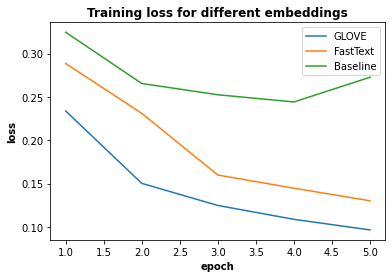

In [38]:
epochRange = np.arange(1,6,1)
plt.plot(epochRange,all_losses['glove_loss'])
plt.plot(epochRange,all_losses['fasttext_loss'])
plt.plot(epochRange,all_losses['baseline_loss'])
plt.title('Training loss for different embeddings', fontweight='bold')
plt.ylabel('loss', fontweight='bold')
plt.xlabel('epoch', fontweight='bold')
plt.legend(['GLOVE','FastText','Baseline'], loc='upper right')
plt.show()

### **6. Summary**

As you can see, GloVe and fastText have minimal difference in terms of AUC scores, but for training losses GloVe seems to do a better job in learning the data. *`I would recommend using word Embeddings, any of GloVe or fastText is just fine.`*

Pretrained word embeddings capture the semantic and syntactic meaning of a word as they are trained on large datasets. They are capable of boosting the performance of a Natural Language Processing (NLP) model.

`If your baseline model on a different dataset gives better result than an Embedded model`, it could be because of:
 
 > the fact that these pretrained embeddings are not trained against text in the same context so the number of common words between our text and text that these pretrained embeddings were trained would be low.
